In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder, OneHotEncoder
#import wrangle
import env
import seaborn as sns
import acquire
import prep
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split


import prep
import seaborn as sns
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
from statsmodels.formula.api import ols

In [8]:
#single family residence from zillow DB
df = prep.prep_df()

In [ ]:
df.head().T

In [9]:
train, test = train_test_split(df, train_size = .75, random_state = 123)
train['tax_per_sqft'] = train.tax_value/train.sqft
test['tax_per_sqft'] = test.tax_value/test.sqft

In [10]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft
12854,2.0,3.0,1838.0,216159.0,6037.0,34613754.0,-118209598.0,9796.0,40227.0,3101.0,97329.0,1999.0,172934.0,0.051355,117.605550
6103,2.0,3.0,2306.0,181378.0,6037.0,33764859.0,-118414326.0,10306.0,33311.0,3101.0,96121.0,1968.0,109124.0,0.005659,78.654814


In [11]:
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000


In [12]:
X_train.head(2)

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,tax_per_sqft
12854,2.0,3.0,1838.0,216.159,9796.0,1999.0,172.934,117.605550
6103,2.0,3.0,2306.0,181.378,10306.0,1968.0,109.124,78.654814


In [6]:
#adding a baseline yhat as mean of log error
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

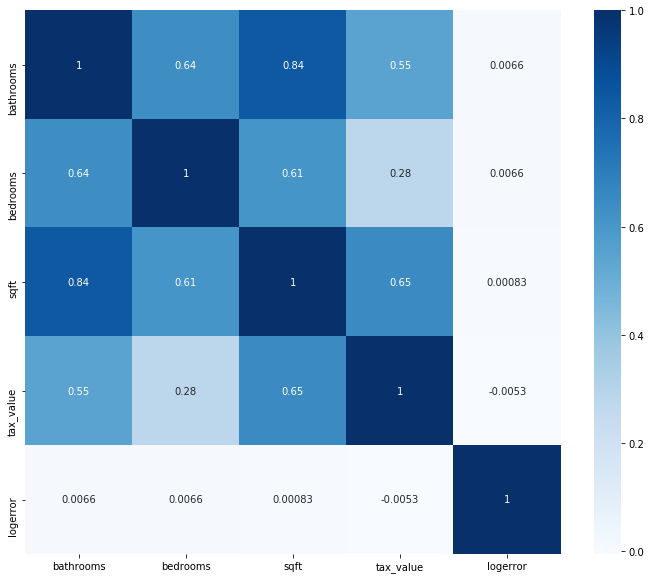

In [7]:
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

In [8]:
# MSE of baseline
train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [9]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)
r2 = ols_model.rsquared
print('r squared = ',round(r2,7))

r squared =  5.88e-05


In [10]:

train['residual^2'] = train.residual ** 2
SSE = sum(train['residual^2'])
MSE = SSE/len(train)
print("MSE = ", MSE)

MSE =  0.028226598428296255


In [ ]:
#Clustered by logerror
train = target_cluster(y_train,X_train)

In [ ]:
train.groupby('cluster').mean().sort_values(by='logerror')

In [94]:
#Model1 performs very slightly better than the baseline
baseline = mean_squared_error(train.logerror,train.mean_logerror)
model1 = mean_squared_error(train.logerror,train.yhat)
print("Baseline: ",baseline)
print("Model1: ",model1)
baseline<model1

Baseline:  0.028226598428296407
Model1:  0.028224938702324065


False

In [ ]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(y_train)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [11]:
def target_cluster(y_train,X_train):
    kmeans =KMeans(n_clusters=3)
    kmeans.fit(y_train)
    y_train['cluster'] = kmeans.predict(y_train)
    train = X_train.merge(y_train,left_index=True,right_index=True)
    return train

In [ ]:
train.cluster.value_counts()

In [ ]:
train.groupby('cluster').logerror.mean()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [13]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',min_samples_leaf=3,n_estimators=100,max_depth=3, random_state=123)

In [16]:
X = train[['bathrooms','sqft','bedrooms']]
y = train.cluster
X = train[['bathrooms','sqft','bedrooms']]
y = train.cluster

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [ ]:
rf.fit(X,y)

In [ ]:
print(rf.feature_importances_)

In [15]:
y_pred = pd.DataFrame(rf.predict(X))
y_pred_proba = rf.predict_proba(X)

NameError: name 'X' is not defined

In [ ]:
rf.score(X,y)

In [ ]:
print(classification_report(y,y_pred))

In [62]:
def x_cluster(X_train,X_test,num_clusters):
    
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_train)
    X_train['x_cluster'] = kmeans.predict(X_train)
    X_test['x_cluster'] = kmeans.predict(X_test)

    return X_train, X_test, kmeans



In [17]:
X_train = train[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']]
X_test = test[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']]

In [18]:
X_train, X_test, kmeans = x_cluster(X_train,X_test)

In [29]:
X_train.head(2)

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet,x_cluster
12854,117.605550,172934.0,9796.0,0
6103,78.654814,109124.0,10306.0,0


In [19]:
kmeans.cluster_centers_

array([[2.03547180e+02, 1.05057212e+05, 8.46177553e+03],
       [5.17151732e+02, 9.77869696e+05, 2.86414243e+04],
       [8.90564101e+02, 3.37494370e+06, 6.38799319e+04],
       [3.01569862e+02, 3.29123800e+05, 1.31805876e+04]])

   k           sse
0  1  2.200600e+15
1  2  1.172139e+15
2  3  7.061731e+14
3  4  4.729185e+14
4  5  3.458738e+14
5  6  2.828713e+14
6  7  2.305076e+14
7  8  1.771164e+14
8  9  1.426603e+14


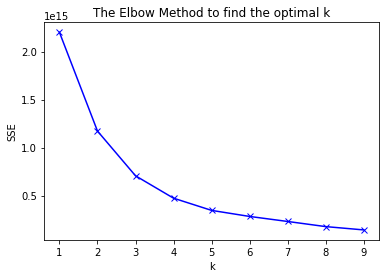

In [22]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [26]:
train = x_cluster(train[['tax_per_sqft','structuretaxvaluedollarcnt','lotsizesquarefeet']],train)

ValueError: Incorrect number of features. Got 19 features, expected 3

In [28]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft,mean_logerror,residual,residual^2,yhat
12854,2.0,3.0,1838.0,216159.0,6037.0,34613754.0,-118209598.0,9796.0,40227.0,3101.0,97329.0,1999.0,172934.0,0.051355,117.605550,0.016239,0.035115,0.001233,0.015716
6103,2.0,3.0,2306.0,181378.0,6037.0,33764859.0,-118414326.0,10306.0,33311.0,3101.0,96121.0,1968.0,109124.0,0.005659,78.654814,0.016239,-0.010581,0.000112,0.015307


In [33]:
X_train.shape

(40908, 4)

In [51]:
X_train.x_cluster.value_counts()

0    31713
3     8098
1     1027
2       70
Name: x_cluster, dtype: int64

In [55]:
X_test.head(2)

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet
47271,190.986264,39723.0,5061.0
53028,204.589474,169900.0,7875.0


In [52]:
#Dropping small cluster groups.
X_train_0_3 = X_train[(X_train.x_cluster == 0) |( X_train.x_cluster == 3)]

In [67]:
X_train_0_3 = X_train_0_3.drop(columns = 'x_cluster')
X_test = X_test.drop(columns='x_cluster')

In [59]:
X_train_0_3.head(2)

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet
12854,117.605550,172934.0,9796.0
6103,78.654814,109124.0,10306.0


In [60]:
X_test.head(2)

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet
47271,190.986264,39723.0,5061.0
53028,204.589474,169900.0,7875.0


   k           sse
0  1  5.734556e+14
1  2  2.489718e+14
2  3  1.607605e+14
3  4  1.074019e+14
4  5  7.290955e+13
5  6  5.672776e+13
6  7  4.481472e+13
7  8  3.489233e+13
8  9  2.900978e+13


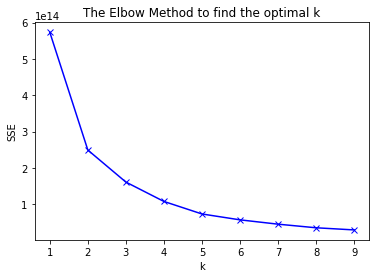

In [61]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_0_3)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [68]:
X_train_0_3, X_test_0_3, kmeans = x_cluster(X_train_0_3,X_test,4)

In [69]:
X_train_0_3.x_cluster.value_counts()

0    23880
2    12534
1     3395
3        2
Name: x_cluster, dtype: int64

In [72]:
#Exploring outliers
X_train_0_3[X_train_0_3.x_cluster == 3]

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet,x_cluster
2466,34.428088,42430.0,3500297.0,3
23676,759.337000,16418.0,6845666.0,3


In [78]:
train_0_3 = X_train_0_3.merge(y_train,how='inner',left_index=True,right_index=True)

In [87]:
train_0_3.shape

(39811, 5)

In [85]:
X_train_0_3 = train_0_3.drop(columns='logerror')

In [88]:
X_train_0_3.shape

(39811, 4)

In [89]:
train_0_3[['logerror']].shape

(39811, 1)

In [91]:
#MSE of clusterd X_train with tax per sqft, structure value, lot size, and cluster
x = X_train_0_3
y = train_0_3[['logerror']]
ols_model = ols('y ~ x', data=train_0_3).fit()
train_0_3['yhat'] = ols_model.predict(x)
r2 = ols_model.rsquared
print('r squared = ',round(r2,7))

r squared =  3.01e-05


In [96]:
#OLS model with clusters
model2 = mean_squared_error(train_0_3.logerror,train_0_3.yhat)
print("Model1: ",model1)
print("Model2: ",model2)

Model1:  0.028224938702324065
Model2:  0.028442392062004985


In [95]:
model2 < model1

False

In [109]:
X_train_0_3.head(2)

,tax_per_sqft,structuretaxvaluedollarcnt,lotsizesquarefeet,x_cluster
12854,117.605550,172934.0,9796.0,2
6103,78.654814,109124.0,10306.0,0


In [116]:
#encoding x_cluster
encoder = LabelEncoder()
encoder.fit(X_train_0_3.x_cluster)
X_train_0_3.encoded = encoder.transform(X_train_0_3.x_cluster)
X_test.encoded = encoder.transform(X_test.x_cluster)

In [117]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()


In [118]:
#Fitting linear regression model to x cluster, price per sq ft, strucure tax value, lot size
regr.fit(X_train_0_3,train_0_3[['logerror']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [119]:
y_pred_0_3_train = regr.predict(X_train_0_3)
y_pred_0_3 = regr.predict(X_test)

In [120]:
#Testing linear regression against test data
mean_squared_error(y_test,y_pred_0_3)

0.033097092370279725